In [50]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import histlite as hl
import csky as cy
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy import stats
#making healpy maps
import h5py as h5
import healpy as hp
import pickle as pkl

In [43]:
import setup
import chime_localizations as loc

#import imp
#imp.reload(bg)

<module 'bg_trials' from '/home/jthwaites/FRB/bg_trials.py'>

In [65]:
mpl.rcParams['font.size'] = 20
ana=cy.CONF['ana']

seed=8
new_nside=512

In [4]:
"""2 trial FRBs: FRB20190416A, dec=33.3 and FRB20190617B, dec= 1.16"""
frbs=setup.load_frbs(spatial_priors=True)

wn=np.where(frbs['src']=='FRB20190416A')
wn=wn[0][0] #want only one of the bursts

ws=np.where(frbs['src']=='FRB20190617B')
ws=ws[0][0]

In [89]:
"""Making background distributions: 
1. point source-like (for comparison)
2. with spatial prior
"""
t_100=100000.
n_trials=1000

Performing 1000 background trials using 5 cores:
       1000/1000 trials complete.   
Performing 1000 background trials using 5 cores:
       1000/1000 trials complete.   


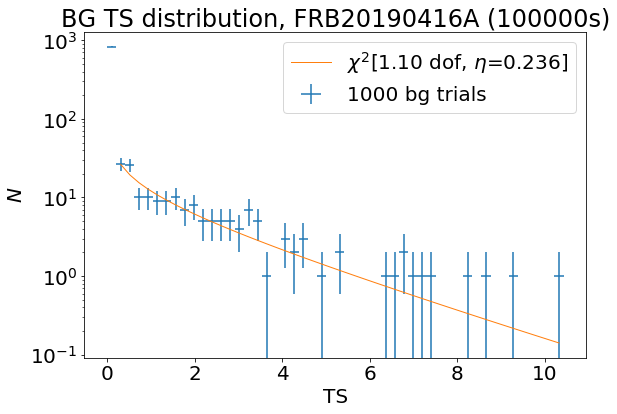

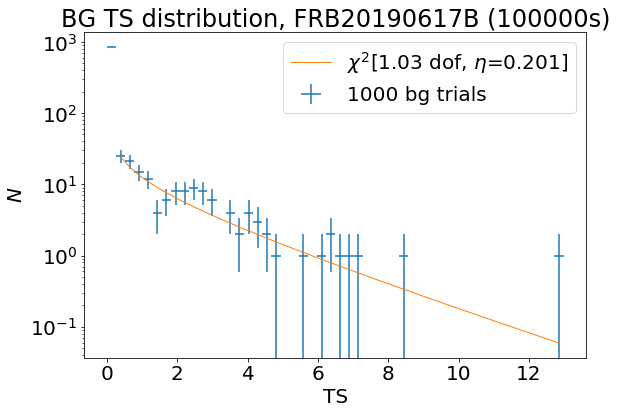

In [86]:
"""Part 1: point source-like"""
import bg_trials as bg
seed=0

for index in [wn,ws]:
    src=setup.sources(t_100, frbs['mjd'].values[index], frbs['ra_deg'].values[index], 
                  frbs['dec_deg'].values[index])
    if index==wn: frb_name= 'FRB20190416A'
    elif index==ws: frb_name='FRB20190617B'
    else: name=' '
    bg.scan_bg(src, seed=seed, n_trials=n_trials, frb_name =frb_name, print_plot=True)

In [92]:
"""Part 2: with spatial prior method"""
trials={}
#seed=2
n_trials=1000
logging=True
make_plot=True

#################

index=wn
#for index in [wn,ws]:
if index==wn: frb_name='FRB20190416A'
elif index==ws: frb_name='FRB20190617B'
else: frb_name=' '

frb_probs, msk=loc.make_healpix_map(frb_name, new_nside=new_nside, max_cl=0.9997)

src=setup.sources(t_100, frbs['mjd'].values[index], frbs['ra_deg'].values[index], 
                  frbs['dec_deg'].values[index])

##sp_tr used for getting llh prior, injecting events
sp_tr = cy.get_spatial_prior_trial_runner(src_tr=src, llh_priors=frb_probs, get_pixmask=True)
##sstr used for each scan
sstr = cy.get_sky_scan_trial_runner(ana=ana, nside=new_nside, 
            src_kw={'mjd':src['mjd'], 't_100':src['t_100'], 'sigma_t':0.}, pixmask=msk)

for seed in range(n_trials):
    scan = sstr.get_one_scan(seed = seed, mp_cpus=15, logging=False)
    
    if max(scan[1])>0.:
        ts_with_prior=np.zeros(len(scan[1]))
        w=np.where(scan[1]>0.)[0]
        for i in w:
            pixel_ts=scan[1][i] + sp_tr.llh_prior_term[0][i]
            ts_with_prior[i]=max([pixel_ts,0])
        scan_max=max(ts_with_prior)
        if scan_max>0.: 
            hottest_pix=np.where(ts_with_prior==scan_max)[0][0]
            hottest_loc=hp.pix2ang(new_nside,hottest_pix,lonlat=True)
        else: 
            hottest_pix=''
            hottest_loc=''
        
        del ts_with_prior
    else: 
        scan_max=max(scan[1])
        hottest_pix=''
        hottest_loc=''

    trials[seed]={'max_TS':scan_max, 'hottest_pix':hottest_pix, 'hottest_loc':hottest_loc} 
    del scan
    
    if logging==True: 
        if (seed+1)%100==0: print('%i / %i trials done'%((seed+1),n_trials))
        
with open('%s_bg_%i.pkl'%(frb_name,t_100), 'wb') as outfile:
    pkl.dump(trials, outfile)
    
if make_plot==True: #making histogram for bg
    """Hist for bg"""
    fig, ax = plt.subplots(figsize=(9,6))
    tss=[]
    for i in range(len(trials)):
        tss.append(trials[i]['max_TS'])
        
    bg = cy.dists.Chi2TSD(tss)
    h = bg.get_hist(bins=50)
    hl.plot1d(ax, h, crosses=True, label='%i bg trials'%(bg.n_total))

    # chi2 fit
    x = h.centers[0][1:]
    norm = h.integrate().values #normalization for chi-sq
    ax.semilogy(x, norm * bg.pdf(x), lw=1, 
            label=r'$\chi^2$[%.2f dof, $\eta$=%.3f]'%(bg.ndof, bg.eta))

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'$N$')
    if src['t_100'][0]==1.: plt.title(r'BG TS distribution, %s, with prior (1d)'%(frb_name))
    else: plt.title(r'BG TS distribution, %s, with prior (%is)'%(frb_name,src['t_100'][0]*84600.))
    ax.legend()

    plt.savefig('/home/jthwaites/public_html/Background_TS/%s_bgts_%is_w_prior.png'
                    %(frb_name,int(src['t_100'][0]*84600.)))

100 / 1000 trials done
200 / 1000 trials done
300 / 1000 trials done
400 / 1000 trials done
500 / 1000 trials done
600 / 1000 trials done
700 / 1000 trials done
exception raised trying to construct <class 'csky.trial.TrialRunner'>


KeyboardInterrupt: 

In [ ]:
"""Signal trials: """

In [ ]:
"""Checking the max penalties by looking at the priors
from csky/trial.py at line 1111

llh_prior_term = []
p=frb_probs

pt = np.where(p > 0, p, 1e-10 * np.min(p[p>0]))
pt = pt / np.sum(pt) /512
pt = np.log(pt)
pt = pt - np.max(pt)
llh_prior_term.append(pt)"""
#pt
#w=np.where(llh_p[0]>0.)[0]
#[llh_p[0][i] for i in w]

In [135]:
##inj signal w sp_tr
nsig=1
sig_trial= sp_tr.get_one_trial(nsig,seed=seed, poisson=True)

##check this fix again, seems ok with utils.py line 286
sig_trial.evss[0][1]['energy']=10**(sig_trial.evss[0][1]['log10energy'])
for i in range(len(sig_trial.evss[0][1])):
    print('ra=%.2f, dec=%.2f'
          %(np.degrees(sig_trial.evss[0][1]['ra'][i]),
            np.degrees(sig_trial.evss[0][1]['dec'][i])))

ra=148.07, dec=33.55
ra=146.94, dec=33.50
ra=146.51, dec=33.36
ra=146.83, dec=33.30


In [136]:
## scan sky, w/in 99.97% CL only - pixmask call
sstr = cy.get_sky_scan_trial_runner(ana=ana, nside=new_nside, 
            src_kw={'mjd':src['mjd'], 't_100':src['t_100'], 'sigma_t':0.}, 
            pixmask=msk)

#%time scan = sstr.get_one_scan(seed = seed, mp_cpus=15, logging=True)

##if signal trial: 
%time scan = sstr.get_one_scan_from_trial(sig_trial, seed = seed, mp_cpus=15, logging=True)

Scanning 226 locations using 15 cores:
        226/226 coordinates complete.   
CPU times: user 86.2 ms, sys: 849 ms, total: 936 ms
Wall time: 2.93 s


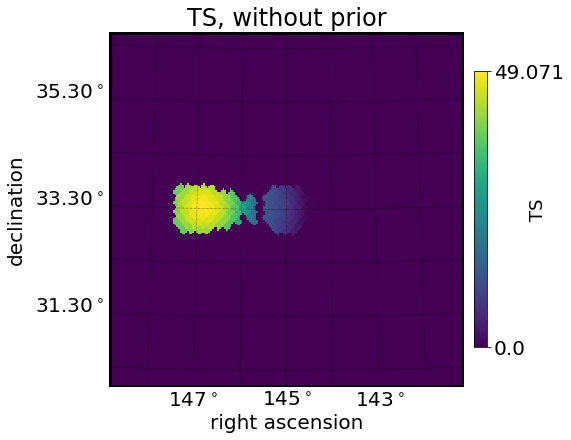

In [137]:
setup.plot_zoom(scan[1], src['ra'][0], src['dec'][0], contour_scan=False, 
                title='TS, without prior', 
                reso=2., col_label=r"TS", cmap='viridis')

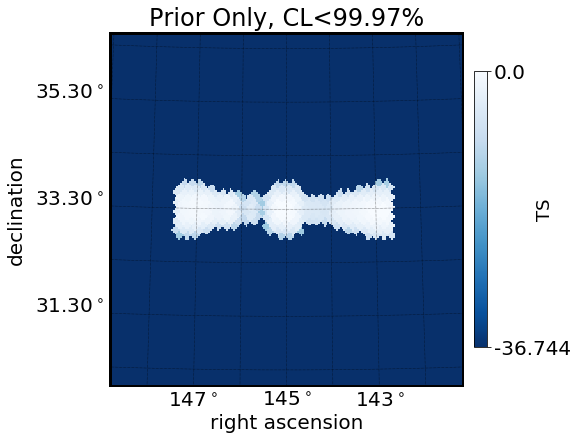

In [138]:
setup.plot_zoom(sp_tr.llh_prior_term[0], src['ra'][0], src['dec'][0], contour_scan=False, 
                title='Prior Only, CL<99.97%',
                reso=2., col_label=r"TS", cmap='Blues')

In [116]:
#make ts_with_prior >=0
ts_with_prior=np.zeros(len(scan[1]))
w=np.where(scan[1]>0.)[0]
for i in w:
    pixel_ts=scan[1][i] + sp_tr.llh_prior_term[0][i]
    ts_with_prior[i]=max([pixel_ts,0])
    
#ts_with_prior = scan[1] + sp_tr.llh_prior_term[0]

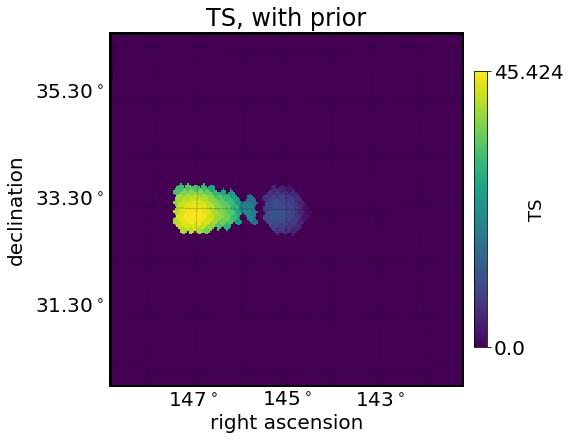

In [117]:
#ts_range=[min(sp_tr.llh_prior_term[0]),max(scan[1])]
setup.plot_zoom(ts_with_prior, src['ra'][0], src['dec'][0], contour_scan=False, 
                title='TS, with prior', 
                reso=2, col_label=r"TS", cmap='viridis')